# 1. Simple mode (no symmetry)

## 1.1 Plot bands from the DFT code

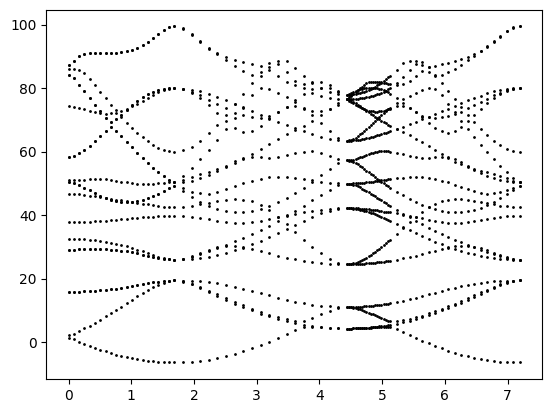

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import scipy

bands_pw = np.loadtxt("../../data/diamond/diamond.bands_pw.dat.gnu")

bohr_ang = scipy.constants.physical_constants['Bohr radius'][0] / 1e-10
alatt = 6.1* bohr_ang
bands_pw[:,0]*= 2*np.pi/alatt

plt.scatter(bands_pw[:, 0], bands_pw[:, 1], s=1, c="black", label="PW bands")
plt.show()



## 2.2 Load Wannier90 files and wannierize them


In [2]:
from wannierberri.w90files import Wannier90data

w90data = Wannier90data().from_w90_files("../../data/diamond/w90files/diamond", readfiles=["win", "mmn", "amn", "eig", "unk"])

froz_max=22

w90data.select_bands(win_min=-np.inf, win_max = froz_max)

w90data.wannierise( init = "amn",
                froz_min=-np.inf,
                froz_max=froz_max,
                print_progress_every=10,
                num_iter=41,
                conv_tol=1e-6,
                mix_ratio_z=1.0,
                sitesym=False,
                )


2025-06-30 00:44:28,873	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


creating empty CheckPoint from Win file
selected_bands = [0 1 2 3]
####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
  0.000000000000    0.000000000000   -0.000000000000   |     0.398647548140
 -0.806995000000    0.806995000000   -0.000000000000   |     0.398647548140
 -0.000000000000    0.806995000000    0.806995000000   |     0.398647548139
 -0.806995000000   -0.000000000000    0.806995000000   |     0.398647548137
----------------------------------------------------------------------------------------------------
 -1.613989999997    1.613990000002    1.613989999996   |     1.594590192556 <- sum
                                          maximal spread =   0.398647548140
#########################

/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/wannierise/wannierizer.py:230: UserWarning: Ray is not initialized, running in serial mode
  warnings.warn("Ray is not initialized, running in serial mode")


## Plot the Wannier functions
`

In [24]:
w90data.plotWF(path="./diamond-bond")
%ls
%pwd

self.unk.grid_size=(9, 9, 9)
reduc_r_points = [1 1 1]
wannier function 0 : Im/Re ratio 0.16986488081976586 ((0.10866083873778297+6.771623257639751e-18j))
wannier function 1 : Im/Re ratio 0.1989985188176194 ((0.1087291141752548+5.559570169485303e-18j))
wannier function 2 : Im/Re ratio 0.19899851889457706 ((0.10872911416927256+5.173251545798452e-18j))
wannier function 3 : Im/Re ratio 0.19899851891546594 ((0.10872911416167232-6.111583196663906e-18j))
diamond-bond0000.xsf  diamond-bond0002.xsf  diamond-wannierise.ipynb
diamond-bond0001.xsf  diamond-bond0003.xsf  Fe_bands.pdf


'/home/stepan/github/wannier-berri-work/tutorial-Dresden-2025/1_Wannierisation/1.diamond'

## 1.3 Create a System() object

This object may be created in many ways (from the .chk file by wannier90, or from FPLO, ASE, or a tight-binding model, even a k.p model)

In [3]:
from wannierberri.system import System_w90
system = System_w90(w90data=w90data)


setting Rvec
expjphase1 (1, 4, 8)
Real-space lattice:
 [[-1.61399  0.       1.61399]
 [ 0.       1.61399  1.61399]
 [-1.61399  1.61399  0.     ]]
Number of wannier functions: 4
Number of R points: 19
Recommended size of FFT grid [2 2 2]


## 1.4 calculate bands along the path and plot them

Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x715acbeb47a0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x715a68b1e750> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x715acbeb47a0>
All calculators are compatible
Symmetrization switched off for Path
Grid is regular
The set of k points is a Path() with 573 points and labels {0: 'L', 134: '$\\Gamma$', 353: 'X', 408: 'K', 572: '$\\Gamma$'}
generating K_list
Done 
Done, sum of weights:573.0
pro

<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
<>:6: SyntaxWarning: invalid escape sequence '\G'
/tmp/ipykernel_566748/2960811462.py:6: SyntaxWarning: invalid escape sequence '\G'
  labels = ["L", "$\Gamma$", "X", "K", "$\Gamma$"],
/tmp/ipykernel_566748/2960811462.py:6: SyntaxWarning: invalid escape sequence '\G'
  labels = ["L", "$\Gamma$", "X", "K", "$\Gamma$"],
/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    573 K-points in serial:     0.3936 ; per K-point          0.0007 ; proc-sec per K-point          0.0007
time1 =  0.014146804809570312
Totally processed 573 K-points 
run() finished


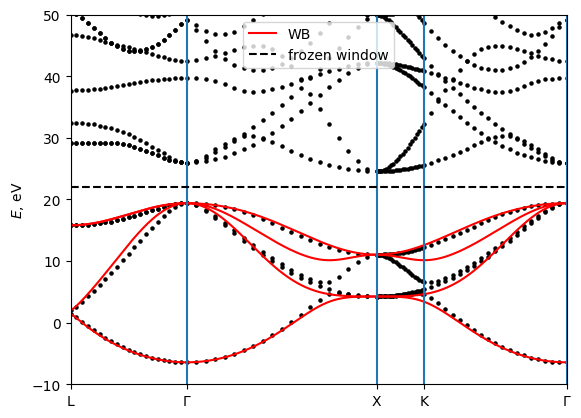

In [4]:
from wannierberri.grid import Path
from wannierberri import evaluate_k_path

path = Path(system=system,
            nodes = [[1/2,1/2,1/2], [0,0,0], [1/2,-1/2,0], [3/8, -3/8, 0], [0,0,0]],
            labels = ["L", "$\Gamma$", "X", "K", "$\Gamma$"],
            length=500)

bands_wb = evaluate_k_path(system=system, path=path)

plt.scatter(bands_pw[:,0], bands_pw[:,1], c="black", s=5)



bands_wb.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=0,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor="red",
                close_fig=False,
                show_fig=False,
                label=f"WB"
                )

# plt.ylim(-10, 40)
plt.hlines(froz_max, 0, bands_pw[-1,0], linestyles="dashed", label="frozen window", color="black")
plt.legend()
plt.show()

## Change the projections

### load the bandstructure directly from DFT code outputs

In [15]:
from wannierberri.symmetry.projections import Projection, ProjectionsSet
from wannierberri.w90files import AMN
from irrep.bandstructure import BandStructure

bandstructure = BandStructure(code="espresso", prefix="../../data/diamond/di")
sg = bandstructure.spacegroup
# sg.show()

positions_atoms = [[1/8,1/8,1/8], [-1/8,-1/8,-1/8]] 
proj_s = Projection(position_num=positions_atoms, orbital="s", spacegroup=sg)
proj_p = Projection(position_num=positions_atoms, orbital="p", spacegroup=sg)
projections = ProjectionsSet([proj_s, proj_p])


amn_sp = AMN.from_bandstructure(bandstructure=bandstructure, projections=projections)

w90data2 = Wannier90data().from_w90_files("../../data/diamond/w90files/diamond", readfiles=["win", "mmn", "eig", "unk"])
w90data2.set_file("amn", amn_sp)


froz_max=35
# w90data.select_bands(win_min=-np.inf, win_max = 100)

w90data2.wannierise(
                init = "amn",
                froz_min=-np.inf,
                froz_max=froz_max,
                print_progress_every=10,
                num_iter=101,
                conv_tol=1e-6,
                mix_ratio_z=1.0,
                sitesym=False,
                )


finding num points from 2 projections
Creating amn. Using projections_set 
ProjectionsSet with 8 Wannier functions and 0 free variables
Projection 0.125, 0.125, 0.125:['s'] with 2 Wannier functions on 2 points (1 per site)
Projection 0.125, 0.125, 0.125:['p'] with 6 Wannier functions on 2 points (3 per site)
creating empty CheckPoint from Win file
####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
 -0.403498000000    0.403498000000    0.403498000000   |     0.542636026053
  0.403497000000   -0.403498000000   -0.403497000000   |     0.542636026275
 -0.403497000000    0.403498000000    0.403498000000   |     0.518941249811
 -0.403498000000    0.403498000000    0.403497000000   |     0.518941249727
 -

/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/wannierise/wannierizer.py:230: UserWarning: Ray is not initialized, running in serial mode
  warnings.warn("Ray is not initialized, running in serial mode")


setting Rvec
expjphase1 (1, 8, 8)
Real-space lattice:
 [[-1.61399  0.       1.61399]
 [ 0.       1.61399  1.61399]
 [-1.61399  1.61399  0.     ]]
Number of wannier functions: 8
Number of R points: 25
Recommended size of FFT grid [2 2 2]
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x715a5903a480>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x715a586a3770> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x715a5903a480>
All calculators are compa

/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    573 K-points in serial:     0.3150 ; per K-point          0.0005 ; proc-sec per K-point          0.0005
time1 =  0.011969327926635742
Totally processed 573 K-points 
run() finished


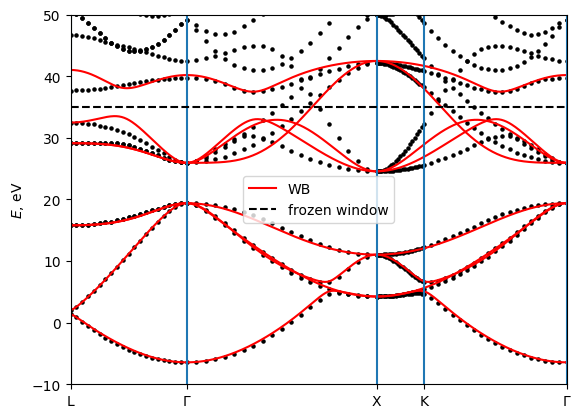

In [16]:
system2 = System_w90(w90data=w90data2)
bands_wb = evaluate_k_path(system=system2, path=path)

plt.scatter(bands_pw[:,0], bands_pw[:,1], c="black", s=5)



bands_wb.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=0,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor="red",
                close_fig=False,
                show_fig=False,
                label=f"WB"
                )

# plt.ylim(-10, 40)
plt.hlines(froz_max, 0, bands_pw[-1,0], linestyles="dashed", label="frozen window", color="black")
plt.legend()
plt.show()

# Symmetry-adapted Wannier Functions

In [17]:
from wannierberri.symmetry.sawf import SymmetrizerSAWF

positions_bonds = [[ 0,0,0], [0,0,1/2], [0,1/2,0], [1/2,0,0] ]
proj_bond = Projection(position_num=positions_bonds,  orbital="s", spacegroup=sg)
proj_sp3 = Projection(position_num=positions_atoms, orbital="sp3", spacegroup=sg)
projections = ProjectionsSet([proj_bond])
projections = ProjectionsSet([proj_s, proj_p])
projections = ProjectionsSet([proj_sp3])


amn_sp = AMN.from_bandstructure(bandstructure=bandstructure, projections=projections)

w90data3 = Wannier90data().from_w90_files("../../data/diamond/w90files/diamond", readfiles=["win", "mmn", "eig", "unk"])
w90data3.set_file("amn", amn_sp)



symmetrizer = SymmetrizerSAWF().from_irrep(bandstructure=bandstructure)
symmetrizer.set_D_wann_from_projections(projections=projections)


w90data3.set_symmetrizer(symmetrizer)
froz_max=30
w90data3.wannierise(
                init = "amn",
                froz_min=-np.inf,
                froz_max=froz_max,
                print_progress_every=10,
                num_iter=101,
                conv_tol=1e-6,
                mix_ratio_z=1.0,
                sitesym=True,
                )


finding num points from 1 projections
Creating amn. Using projections_set 
ProjectionsSet with 8 Wannier functions and 0 free variables
Projection 0.125, 0.125, 0.125:['sp3'] with 8 Wannier functions on 2 points (4 per site)
creating empty CheckPoint from Win file
mpgrid = [2 2 2], 8
grid: (np.int64(2), np.int64(2), np.int64(2)), selected_kpoints: [0 1 2 3 4 5 6 7]
orbitals = ['sp3']
calculating Wannier functions for sp3 at [[ 0.125  0.125  0.125]
 [-0.125 -0.125 -0.125]]
D.shape [(3, 48, 8, 8)]
num_wann 8
D_wann_block_indices [[0 8]]
####################################################################################################
starting WFs
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
 -0.326032000000    0.480963000000    0.480963000000   |     0.539546840209
 -0.326032000000    0.326032000000    0

/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/wannierise/wannierizer.py:230: UserWarning: Ray is not initialized, running in serial mode
  warnings.warn("Ray is not initialized, running in serial mode")


####################################################################################################
Iteration 10 (from wannierizer)
----------------------------------------------------------------------------------------------------
wannier centers and spreads
----------------------------------------------------------------------------------------------------
 -0.331555000000    0.475440000000    0.475440000000   |     0.514968818315
 -0.331555000000    0.331555000000    0.331555000000   |     0.514968818315
 -0.475440000000    0.475440000000    0.331555000000   |     0.514968818315
 -0.475440000000    0.331555000000    0.475440000000   |     0.514968818315
  0.535382000000   -0.271613000000   -0.271613000000   |     0.514968818315
  0.535382000000   -0.535382000000   -0.535382000000   |     0.514968818315
  0.271613000000   -0.271613000000   -0.535382000000   |     0.514968818315
  0.271613000000   -0.535382000000   -0.271613000000   |     0.514968818315
-----------------------------

setting Rvec
expjphase1 (1, 8, 8)
Real-space lattice:
 [[-1.61399  0.       1.61399]
 [ 0.       1.61399  1.61399]
 [-1.61399  1.61399  0.     ]]
Number of wannier functions: 8
Number of R points: 25
Recommended size of FFT grid [2 2 2]
Starting run()
Using the follwing calculators : 
############################################################

 'tabulate'  :  <wannierberri.calculators.tabulate.TabulatorAll object at 0x715a7019bbc0>  : 
    TabulatorAll - a pack of all k-resolved calculators (Tabulators)
    
 Includes the following tabulators : 
--------------------------------------------------
 "Energy" : <wannierberri.calculators.tabulate.Energy object at 0x715a69784830> : calculator not described

--------------------------------------------------

############################################################
Calculation along a path - checking calculators for compatibility
tabulate <wannierberri.calculators.tabulate.TabulatorAll object at 0x715a7019bbc0>
All calculators are compa

/home/stepan/github/wannier-berri-work/wannier-berri-eig-mmn/wannierberri/grid/path.py:163: UserWarning: symmetry is not used for a tabulation along path
  warnings.warn("symmetry is not used for a tabulation along path")


time for processing    573 K-points in serial:     0.4289 ; per K-point          0.0007 ; proc-sec per K-point          0.0007
time1 =  0.015759944915771484
Totally processed 573 K-points 
run() finished


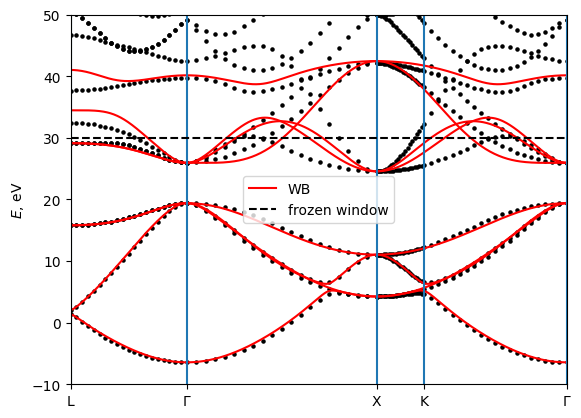

In [18]:
system3 = System_w90(w90data=w90data3, symmetrize=True)
bands_wb = evaluate_k_path(system=system3, path=path)

plt.scatter(bands_pw[:,0], bands_pw[:,1], c="black", s=5)



bands_wb.plot_path_fat(path,
                quantity=None,
                # save_file="Fe_bands.pdf",
                Eshift=0,
                Emin=-10, Emax=50,
                iband=None,
                mode="fatband",
                fatfactor=20,
                cut_k=False,
                linecolor="red",
                close_fig=False,
                show_fig=False,
                label=f"WB"
                )

# plt.ylim(-10, 40)
plt.hlines(froz_max, 0, bands_pw[-1,0], linestyles="dashed", label="frozen window", color="black")
plt.legend()
plt.show()